# Gut Microbiome Machine Learning Pipeline
# Part 2: Feature Engineering & Disease-Specific Classification Models


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, balanced_accuracy_score,
                             make_scorer)

sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# 1. Load Preprocessed Data from EDA

In [2]:
# Define paths (assuming EDA script has been run)
data_dir = "data"
RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")

# Ensure ML results directory exists
ML_FIGS = os.path.join(RESULTS, "ml_figures")
ML_TABLES = os.path.join(RESULTS, "ml_tables")
os.makedirs(ML_FIGS, exist_ok=True)
os.makedirs(ML_TABLES, exist_ok=True)


In [3]:
# Load preprocessed data from EDA
print("Loading preprocessed data from EDA...")

ab_clr = pd.read_csv(os.path.join(TABLES, "abundance_clr.csv"), index_col=0)
meta = pd.read_csv(os.path.join(TABLES, "metadata_with_disease_groups.csv"), index_col=0)
alpha = pd.read_csv(os.path.join(TABLES, "alpha_diversity.csv"), index_col=0)

# Load original relative abundance for feature engineering
ab_rel = pd.read_csv(os.path.join(TABLES, "abundance_filtered_relative.csv"), index_col=0)

print(f"\nLoaded data:")
print(f"  CLR-transformed abundances: {ab_clr.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Alpha diversity: {alpha.shape}")
print(f"  Relative abundances: {ab_rel.shape}")

# Align all datasets
common_idx = ab_clr.index.intersection(meta.index).intersection(alpha.index)
ab_clr = ab_clr.loc[common_idx]
ab_rel = ab_rel.loc[common_idx]
meta = meta.loc[common_idx]
alpha = alpha.loc[common_idx]

print(f"\nAfter alignment: {len(common_idx)} samples")


Loading preprocessed data from EDA...

Loaded data:
  CLR-transformed abundances: (1831, 362)
  Metadata: (1831, 28)
  Alpha diversity: (1831, 5)
  Relative abundances: (1831, 362)

After alignment: 1831 samples


# 2. Feature Engineering

In [4]:
def engineer_ratio_features(ab_rel, top_n=50):
    """
    Create ratio features between abundant taxa.
    These can capture ecological relationships.
    """
    print("\nEngineering ratio features...")

    # Select top N most abundant taxa
    mean_abundance = ab_rel.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    ratio_features = pd.DataFrame(index=ab_rel.index)

    # Create key ratios (Firmicutes/Bacteroidetes, etc.)
    # This is a simplified example - you could create more domain-specific ratios
    for i, taxon1 in enumerate(top_taxa[:10]):
        for taxon2 in top_taxa[i+1:15]:
            ratio_name = f"ratio_{taxon1[:20]}_{taxon2[:20]}"
            ratio_features[ratio_name] = np.log10(
                (ab_rel[taxon1] + 1e-6) / (ab_rel[taxon2] + 1e-6)
            )

    print(f"  Created {ratio_features.shape[1]} ratio features")
    return ratio_features


In [5]:
def engineer_clinical_features(meta):
    """
    Extract and engineer features from clinical metadata.
    """
    print("\nEngineering clinical features...")

    clinical_features = pd.DataFrame(index=meta.index)
    n_features = 0

    # 1. BMI features
    if 'BMI' in meta.columns:
        clinical_features['BMI'] = meta['BMI'].astype(float)
        clinical_features['is_obese'] = (meta['BMI'] >= 30).astype(float)
        clinical_features['is_overweight'] = ((meta['BMI'] >= 25) & (meta['BMI'] < 30)).astype(float)
        n_features += 3
        print(f"  ✓ BMI features: {meta['BMI'].notna().sum()} samples with data")

    # 2. Age categories
    if 'age_category' in meta.columns:
        age_dummies = pd.get_dummies(meta['age_category'], prefix='age', drop_first=True)
        clinical_features = pd.concat([clinical_features, age_dummies], axis=1)
        n_features += age_dummies.shape[1]
        print(f"  ✓ Age categories: {age_dummies.shape[1]} features")

    # 3. Gender
    if 'gender' in meta.columns:
        clinical_features['is_male'] = (meta['gender'].str.lower() == 'male').astype(float)
        n_features += 1
        print(f"  ✓ Gender: {clinical_features['is_male'].notna().sum()} samples")

    # 4. Metabolic markers (z-scored)
    metabolic_markers = ['triglycerides', 'hba1c', 'LDL', 'HDL', 'hsCRP']
    for marker in metabolic_markers:
        if marker in meta.columns:
            values = meta[marker].astype(float)
            if values.notna().sum() > 10:  # Only if enough data
                mean = values.mean()
                std = values.std()
                if std > 0:
                    clinical_features[f'{marker}_zscore'] = (values - mean) / std
                    n_features += 1
                    print(f"  ✓ {marker}: {values.notna().sum()} samples")

    # 5. Smoking status
    if 'smoke' in meta.columns:
        clinical_features['is_smoker'] = meta['smoke'].notna().astype(float)
        n_features += 1

    # 6. Antibiotic use
    if 'antibiotic_use' in meta.columns:
        clinical_features['antibiotic_yes'] = (meta['antibiotic_use'] == 'yes').astype(float)
        clinical_features['antibiotic_unknown'] = (meta['antibiotic_use'] == 'unknown').astype(float)
        n_features += 2
        print(f"  ✓ Antibiotics: yes={clinical_features['antibiotic_yes'].sum()}, "
              f"unknown={clinical_features['antibiotic_unknown'].sum()}")

    # 7. Country/Region (if available)
    if 'country' in meta.columns:
        country_counts = meta['country'].value_counts()
        common_countries = country_counts[country_counts > 50].index
        if len(common_countries) > 1:
            meta['country_grouped'] = meta['country'].apply(
                lambda x: x if x in common_countries else 'other'
            )
            country_dummies = pd.get_dummies(meta['country_grouped'], prefix='country', drop_first=True)
            clinical_features = pd.concat([clinical_features, country_dummies], axis=1)
            n_features += country_dummies.shape[1]
            print(f"  ✓ Country: {country_dummies.shape[1]} features")

    print(f"\nTotal clinical features: {n_features}")

    return clinical_features


In [6]:
def combine_feature_sets(ab_clr, alpha, clinical_features=None, ratio_features=None):
    """
    Combine different feature sets into a single matrix.
    """
    print("\nCombining feature sets...")

    feature_sets = [ab_clr]
    feature_names = ['microbiome_clr']

    # Add alpha diversity
    if alpha is not None:
        alpha_subset = alpha[['richness', 'shannon', 'simpson']]
        feature_sets.append(alpha_subset)
        feature_names.append('alpha_diversity')

    # Add ratio features
    if ratio_features is not None:
        feature_sets.append(ratio_features)
        feature_names.append('ratio_features')

    # Add clinical features
    if clinical_features is not None:
        feature_sets.append(clinical_features)
        feature_names.append('clinical')

    # Combine
    X_combined = pd.concat(feature_sets, axis=1)

    # Handle missing values
    # Binary features: fill with 0
    # Continuous: fill with median
    for col in X_combined.columns:
        if X_combined[col].isna().any():
            if X_combined[col].nunique() <= 2:
                X_combined[col] = X_combined[col].fillna(0)
            else:
                X_combined[col] = X_combined[col].fillna(X_combined[col].median())

    print(f"\nCombined feature matrix: {X_combined.shape}")
    print(f"Feature sets included: {', '.join(feature_names)}")
    print(f"Missing values remaining: {X_combined.isna().sum().sum()}")

    return X_combined


In [7]:
# Create feature sets
ratio_features = engineer_ratio_features(ab_rel, top_n=50)
clinical_features = engineer_clinical_features(meta)

# Combine all features
X_full = combine_feature_sets(ab_clr, alpha, clinical_features, ratio_features)

# Also create microbiome-only version for comparison
X_microbiome = ab_clr.copy()

print(f"\nFeature matrices created:")
print(f"  Microbiome-only: {X_microbiome.shape}")
print(f"  Full (microbiome + clinical + ratios): {X_full.shape}")



Engineering ratio features...
  Created 95 ratio features

Engineering clinical features...
  ✓ BMI features: 1310 samples with data
  ✓ Age categories: 1 features
  ✓ Gender: 1831 samples
  ✓ triglycerides: 844 samples
  ✓ hba1c: 839 samples
  ✓ LDL: 841 samples
  ✓ hsCRP: 829 samples
  ✓ Antibiotics: yes=783.0, unknown=104.0
  ✓ Country: 2 features

Total clinical features: 14

Combining feature sets...

Combined feature matrix: (1831, 474)
Feature sets included: microbiome_clr, alpha_diversity, ratio_features, clinical
Missing values remaining: 0

Feature matrices created:
  Microbiome-only: (1831, 362)
  Full (microbiome + clinical + ratios): (1831, 474)


# 3. Disease-Specific Classification Models

In [8]:
def train_disease_specific_model(X, meta, disease_group, model_type='logistic',
                                  n_cv_folds=5, feature_selection=None, n_features=100):
    """
    Train a classification model for a specific disease group vs. controls.

    Parameters:
    -----------
    X : DataFrame - Feature matrix
    meta : DataFrame - Metadata with disease_group column
    disease_group : str - Disease group to model ('metabolic' or 'cardiovascular')
    model_type : str - 'logistic' or 'random_forest'
    n_cv_folds : int - Number of cross-validation folds
    feature_selection : str - 'univariate', 'mutual_info', or None
    n_features : int - Number of features to select (if feature_selection is not None)
    """
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL: {disease_group.upper()} vs CONTROL")
    print('='*70)

    # Select samples: disease group + controls
    control_idx = meta['disease_group'] == 'control'
    disease_idx = meta['disease_group'] == disease_group
    selected_idx = control_idx | disease_idx

    X_subset = X.loc[selected_idx]
    y_subset = disease_idx[selected_idx].astype(int).values

    n_disease = y_subset.sum()
    n_control = (y_subset == 0).sum()

    print(f"\nDataset:")
    print(f"  Controls: {n_control}")
    print(f"  {disease_group.capitalize()}: {n_disease}")
    print(f"  Features: {X_subset.shape[1]}")
    print(f"  Class balance: {n_disease / (n_disease + n_control):.2%} disease")

    # Feature selection
    if feature_selection == 'univariate':
        print(f"\nPerforming univariate feature selection (top {n_features})...")
        selector = SelectKBest(f_classif, k=min(n_features, X_subset.shape[1]))
        X_subset_transformed = selector.fit_transform(X_subset.values, y_subset)
        selected_features = X_subset.columns[selector.get_support()].tolist()
        print(f"  Selected {len(selected_features)} features")
        X_subset = pd.DataFrame(X_subset_transformed,
                               index=X_subset.index,
                               columns=selected_features)

    # Initialize model
    if model_type == 'logistic':
        model = LogisticRegressionCV(
            cv=5,
            penalty='l2',
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1,
            scoring='roc_auc'
        )
        print(f"\nModel: Logistic Regression with L2 regularization")
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )
        print(f"\nModel: Random Forest")

    # Cross-validation evaluation
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"\nPerforming {n_cv_folds}-fold cross-validation...")
    cv_results = cross_validate(
        model, X_subset.values, y_subset,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Print results
    print(f"\nCross-Validation Results:")
    print(f"{'Metric':<15} {'Train':<20} {'Test':<20}")
    print('-'*55)

    results_dict = {}
    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()

        results_dict[metric] = {
            'train_mean': train_mean,
            'train_std': train_std,
            'test_mean': test_mean,
            'test_std': test_std
        }

        print(f"{metric:<15} {train_mean:.3f} ± {train_std:.3f}      "
              f"{test_mean:.3f} ± {test_std:.3f}")

    # Check for overfitting
    auc_gap = results_dict['roc_auc']['train_mean'] - results_dict['roc_auc']['test_mean']
    if auc_gap > 0.1:
        print(f"\nWarning: Possible overfitting (train-test AUC gap: {auc_gap:.3f})")

    # Fit model on full dataset for feature importance
    model.fit(X_subset.values, y_subset)

    # Extract feature importance
    feature_importance = None
    if model_type == 'logistic':
        coefs = model.coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nTop 15 Features (Logistic Regression Coefficients):")
        print(f"{'Feature':<50} {'Coefficient':>12} {'Direction'}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            direction = '↑ Disease' if row['coefficient'] > 0 else '↓ Disease'
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['coefficient']:>12.4f}  {direction}")

    elif model_type == 'random_forest':
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Features (Random Forest Importance):")
        print(f"{'Feature':<50} {'Importance':>12}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'cv_results': results_dict,
        'feature_importance': feature_importance,
        'X_train': X_subset,
        'y_train': y_subset,
        'n_control': n_control,
        'n_disease': n_disease
    }


# 4. Train Models for Each Disease Group

In [9]:

print("TRAINING DISEASE-SPECIFIC MODELS")

results = {}


TRAINING DISEASE-SPECIFIC MODELS


In [10]:
# Metabolic diseases (IGT, T2D) vs Controls
print("METABOLIC DISEASES")

results['metabolic_microbiome'] = train_disease_specific_model(
    X_microbiome, meta,
    disease_group='metabolic',
    model_type='logistic',
    n_cv_folds=5
)


METABOLIC DISEASES

TRAINING MODEL: METABOLIC vs CONTROL

Dataset:
  Controls: 642
  Metabolic: 825
  Features: 362
  Class balance: 56.24% disease

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.826 ± 0.032      0.720 ± 0.018
accuracy        0.752 ± 0.029      0.656 ± 0.019
balanced_acc    0.752 ± 0.030      0.655 ± 0.018
precision       0.797 ± 0.027      0.708 ± 0.014
recall          0.749 ± 0.027      0.661 ± 0.031
f1              0.772 ± 0.027      0.683 ± 0.022


Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
Escherichia coli                                         0.0891  ↑ Disease
[Bacteroides] pectinophilus                          

In [11]:
results['metabolic_full'] = train_disease_specific_model(
    X_full, meta,
    disease_group='metabolic',
    model_type='logistic',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150
)



TRAINING MODEL: METABOLIC vs CONTROL

Dataset:
  Controls: 642
  Metabolic: 825
  Features: 474
  Class balance: 56.24% disease

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.965 ± 0.003      0.912 ± 0.014
accuracy        0.894 ± 0.008      0.827 ± 0.026
balanced_acc    0.894 ± 0.007      0.826 ± 0.024
precision       0.915 ± 0.005      0.856 ± 0.016
recall          0.895 ± 0.011      0.833 ± 0.043
f1              0.905 ± 0.007      0.844 ± 0.026

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
is_overweight                                            6.5005  ↑ Dis

In [12]:
# Cardiovascular diseases (CAD, HF) vs Controls
print("\n" + "/"*70)
print("CARDIOVASCULAR DISEASES")
print("/"*70)

results['cardiovascular_microbiome'] = train_disease_specific_model(
    X_microbiome, meta,
    disease_group='cardiovascular',
    model_type='logistic',
    n_cv_folds=5
)



//////////////////////////////////////////////////////////////////////
CARDIOVASCULAR DISEASES
//////////////////////////////////////////////////////////////////////

TRAINING MODEL: CARDIOVASCULAR vs CONTROL

Dataset:
  Controls: 642
  Cardiovascular: 364
  Features: 362
  Class balance: 36.18% disease

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.878 ± 0.029      0.731 ± 0.016
accuracy        0.790 ± 0.034      0.669 ± 0.019
balanced_acc    0.792 ± 0.035      0.664 ± 0.021
precision       0.677 ± 0.041      0.536 ± 0.022
recall          0.802 ± 0.038      0.646 ± 0.045
f1              0.735 ± 0.040      0.585 ± 0.027


Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
-----------------------------------------

In [13]:
results['cardiovascular_full'] = train_disease_specific_model(
    X_full, meta,
    disease_group='cardiovascular',
    model_type='logistic',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150
)



TRAINING MODEL: CARDIOVASCULAR vs CONTROL

Dataset:
  Controls: 642
  Cardiovascular: 364
  Features: 474
  Class balance: 36.18% disease

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.975 ± 0.003      0.891 ± 0.018
accuracy        0.920 ± 0.006      0.817 ± 0.016
balanced_acc    0.927 ± 0.006      0.813 ± 0.019
precision       0.844 ± 0.009      0.726 ± 0.035
recall          0.955 ± 0.008      0.799 ± 0.053
f1              0.896 ± 0.007      0.759 ± 0.022

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
country_DNK                                              4.2

# 5. Model Comparison Visualization

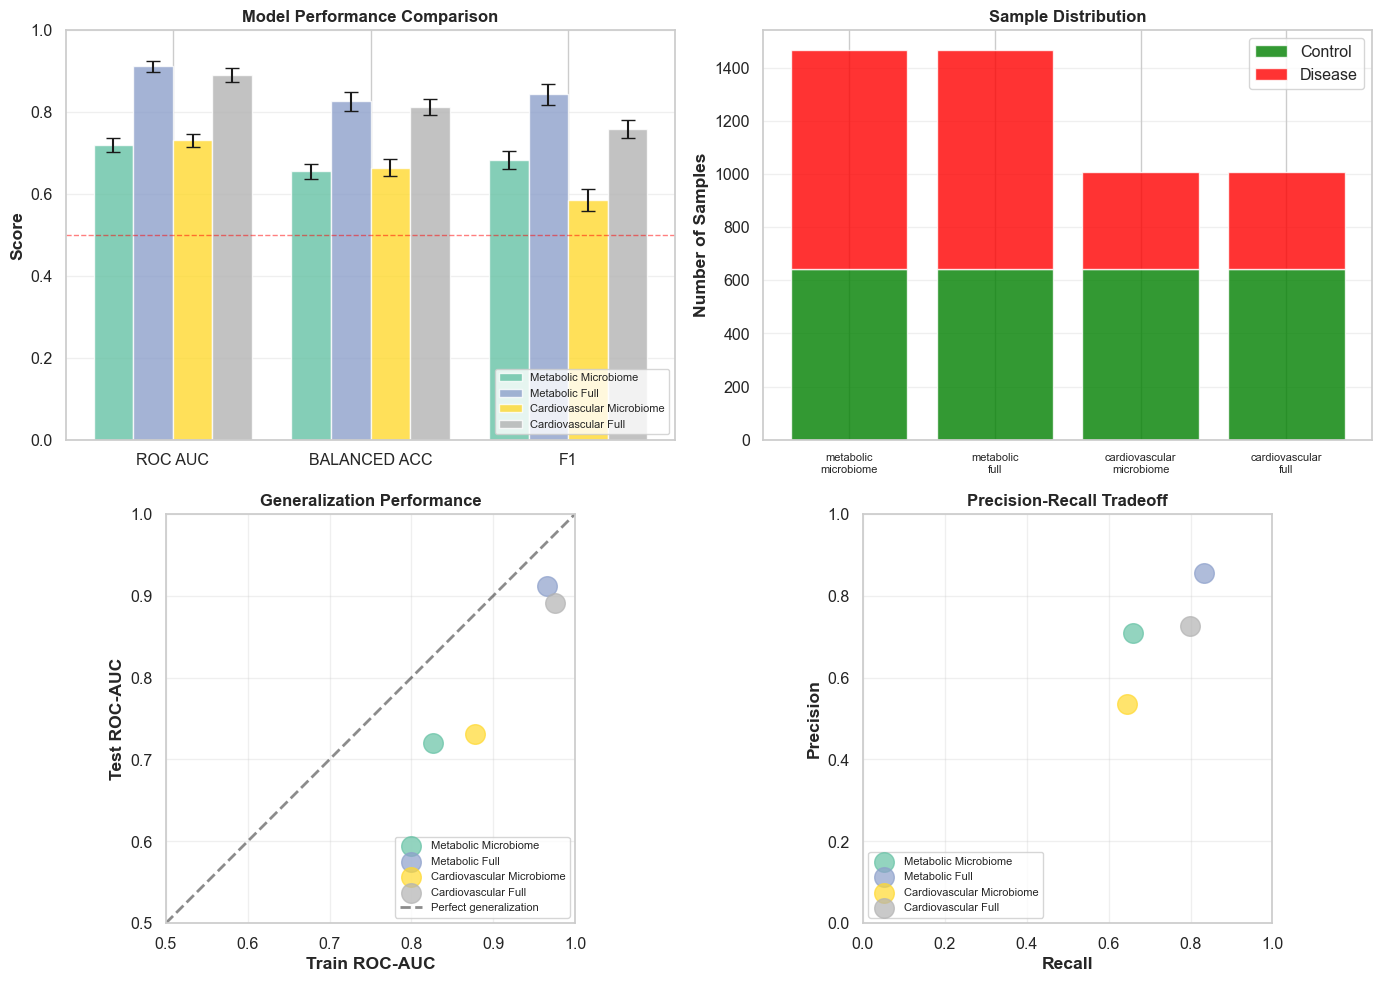

In [14]:
def plot_model_comparison(results_dict):
    """
    Create comprehensive comparison plots for all models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    models = list(results_dict.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

    # 1. Performance metrics comparison
    ax = axes[0, 0]
    x = np.arange(len(metrics))
    width = 0.2

    for i, (model_name, color) in enumerate(zip(models, colors)):
        values = [results_dict[model_name]['cv_results'][m]['test_mean'] for m in metrics]
        errors = [results_dict[model_name]['cv_results'][m]['test_std'] for m in metrics]

        ax.bar(x + i*width, values, width, yerr=errors,
               label=model_name.replace('_', ' ').title(),
               alpha=0.8, capsize=5, color=color)

    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1)

    # 2. Sample sizes
    ax = axes[0, 1]
    sample_data = []
    for model_name in models:
        sample_data.append({
            'model': model_name.replace('_', '\n'),
            'control': results_dict[model_name]['n_control'],
            'disease': results_dict[model_name]['n_disease']
        })

    df_samples = pd.DataFrame(sample_data)
    x_pos = np.arange(len(df_samples))

    ax.bar(x_pos, df_samples['control'], label='Control', alpha=0.8, color='green')
    ax.bar(x_pos, df_samples['disease'], bottom=df_samples['control'],
           label='Disease', alpha=0.8, color='red')

    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title('Sample Distribution', fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 3. Train vs Test AUC (overfitting check)
    ax = axes[1, 0]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        train_auc = results_dict[model_name]['cv_results']['roc_auc']['train_mean']
        test_auc = results_dict[model_name]['cv_results']['roc_auc']['test_mean']

        ax.scatter(train_auc, test_auc, s=200, alpha=0.7, color=color,
                  label=model_name.replace('_', ' ').title())

    # Diagonal line (perfect generalization)
    lim = [0.5, 1.0]
    ax.plot(lim, lim, 'k--', alpha=0.5, linewidth=2, label='Perfect generalization')

    ax.set_xlabel('Train ROC-AUC', fontweight='bold')
    ax.set_ylabel('Test ROC-AUC', fontweight='bold')
    ax.set_title('Generalization Performance', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')

    # 4. Precision-Recall tradeoff
    ax = axes[1, 1]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        precision = results_dict[model_name]['cv_results']['precision']['test_mean']
        recall = results_dict[model_name]['cv_results']['recall']['test_mean']

        ax.scatter(recall, precision, s=200, alpha=0.7, color=color,
                  label=model_name.replace('_', ' ').title())

    ax.set_xlabel('Recall', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall Tradeoff', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'model_comparison_comprehensive.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison(results)


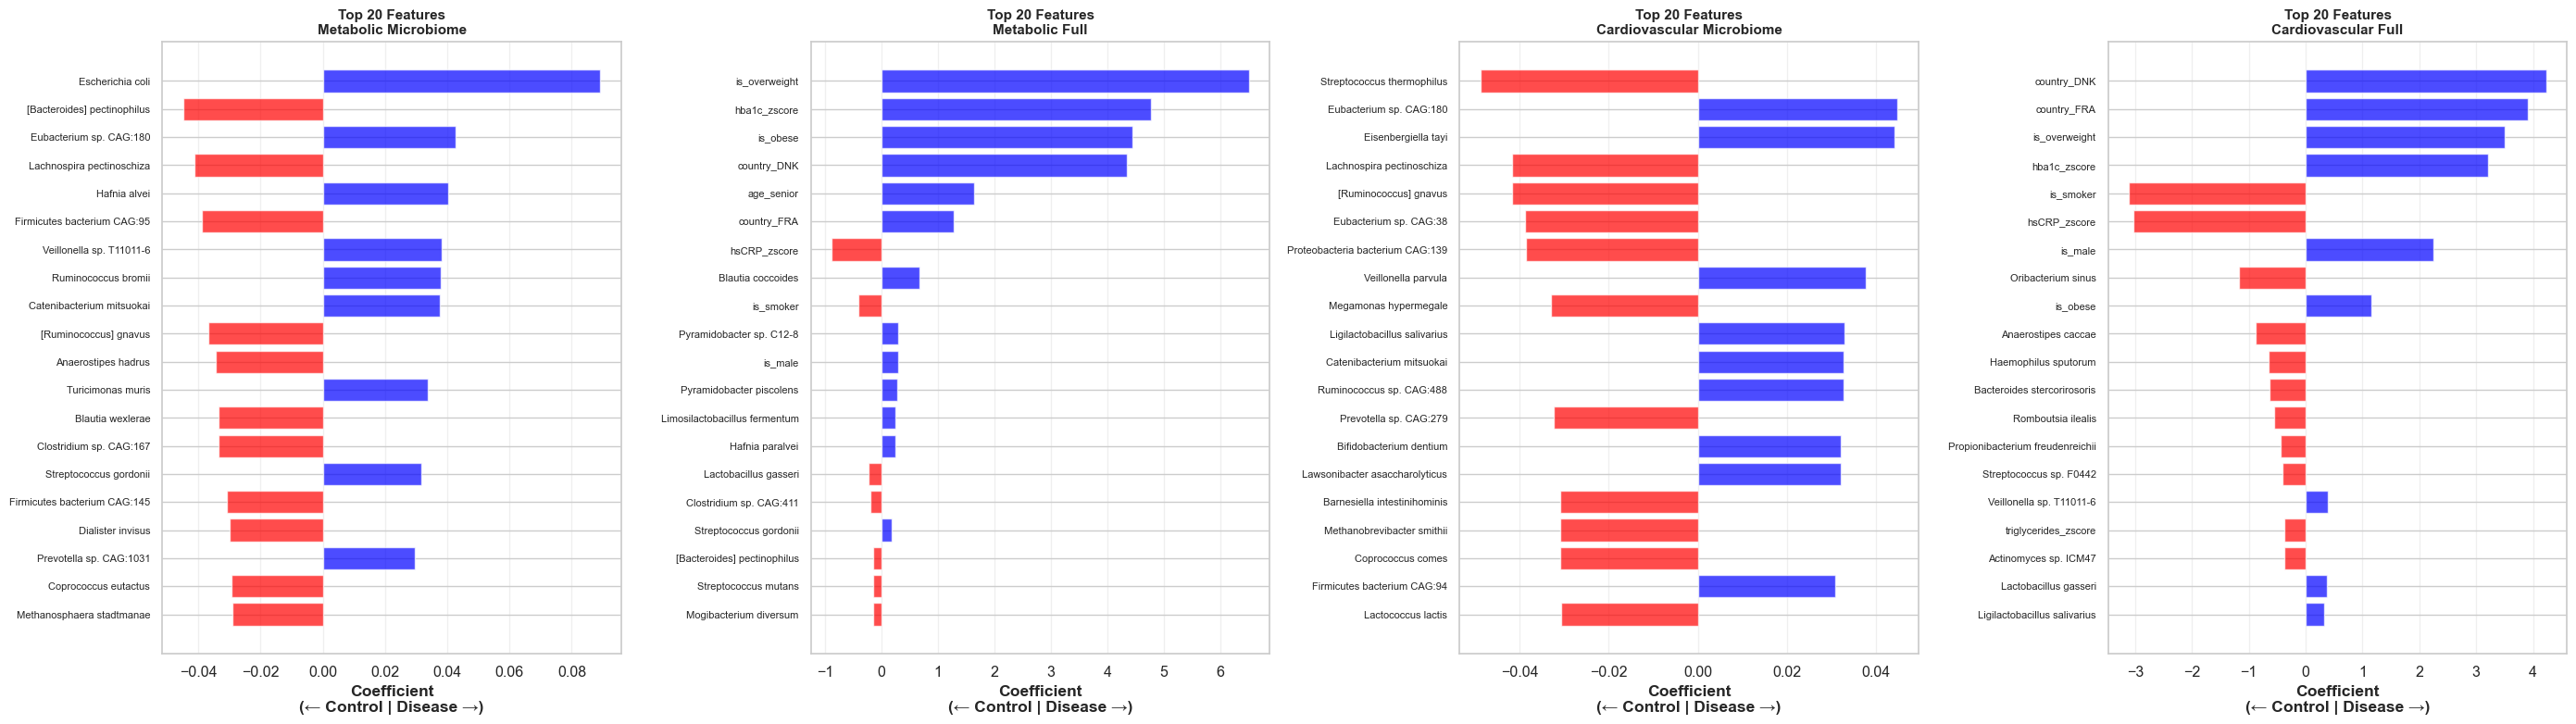

In [15]:
def plot_feature_importance_comparison(results_dict):
    """
    Plot top features for each model side-by-side.
    """
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 8))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, result) in zip(axes, results_dict.items()):
        fi = result['feature_importance']
        if fi is None:
            continue

        top_features = fi.head(20)

        if 'coefficient' in fi.columns:
            # Logistic regression
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['coefficient'], color=colors, alpha=0.7)
            ax.set_xlabel('Coefficient\n(← Control | Disease →)', fontweight='bold')
        else:
            # Random forest
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7)
            ax.set_xlabel('Feature Importance', fontweight='bold')

        # Shorten feature names for display
        feature_labels = [f[:40] + '...' if len(f) > 40 else f
                         for f in top_features['feature']]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=8)
        ax.invert_yaxis()
        ax.set_title(f'Top 20 Features\n{model_name.replace("_", " ").title()}',
                    fontweight='bold', fontsize=11)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'feature_importance_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_importance_comparison(results)


# 6. Save Results

In [16]:
print("SAVING RESULTS")

# Create summary table
summary_data = []
for model_name, result in results.items():
    cv = result['cv_results']
    summary_data.append({
        'Model': model_name,
        'Disease_Group': 'metabolic' if 'metabolic' in model_name else 'cardiovascular',
        'Feature_Set': 'microbiome_only' if 'microbiome' in model_name else 'full',
        'N_Controls': result['n_control'],
        'N_Disease': result['n_disease'],
        'ROC_AUC_mean': cv['roc_auc']['test_mean'],
        'ROC_AUC_std': cv['roc_auc']['test_std'],
        'Balanced_Acc_mean': cv['balanced_acc']['test_mean'],
        'Balanced_Acc_std': cv['balanced_acc']['test_std'],
        'Precision_mean': cv['precision']['test_mean'],
        'Recall_mean': cv['recall']['test_mean'],
        'F1_mean': cv['f1']['test_mean']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(ML_TABLES, 'model_performance_summary.csv'), index=False)

print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))


SAVING RESULTS

Model Performance Summary:
                    Model  Disease_Group     Feature_Set  N_Controls  N_Disease  ROC_AUC_mean  ROC_AUC_std  Balanced_Acc_mean  Balanced_Acc_std  Precision_mean  Recall_mean  F1_mean
     metabolic_microbiome      metabolic microbiome_only         642        825      0.719689     0.017986           0.655085          0.017870        0.707627     0.660606 0.683075
           metabolic_full      metabolic            full         642        825      0.912383     0.013592           0.826005          0.023673        0.855546     0.832727 0.843507
cardiovascular_microbiome cardiovascular microbiome_only         642        364      0.731378     0.016338           0.663970          0.020680        0.535711     0.645624 0.584808
      cardiovascular_full cardiovascular            full         642        364      0.890824     0.018138           0.813245          0.019287        0.726287     0.799467 0.759372


In [17]:
# Save feature importance for each model
for model_name, result in results.items():
    if result['feature_importance'] is not None:
        filename = f'feature_importance_{model_name}.csv'
        result['feature_importance'].to_csv(
            os.path.join(ML_TABLES, filename),
            index=False
        )
        print(f"  Saved: {filename}")


  Saved: feature_importance_metabolic_microbiome.csv
  Saved: feature_importance_metabolic_full.csv
  Saved: feature_importance_cardiovascular_microbiome.csv
  Saved: feature_importance_cardiovascular_full.csv


In [18]:
# Save detailed CV results
cv_detailed = []
for model_name, result in results.items():
    for metric, values in result['cv_results'].items():
        cv_detailed.append({
            'Model': model_name,
            'Metric': metric,
            'Train_Mean': values['train_mean'],
            'Train_Std': values['train_std'],
            'Test_Mean': values['test_mean'],
            'Test_Std': values['test_std']
        })

cv_detailed_df = pd.DataFrame(cv_detailed)
cv_detailed_df.to_csv(os.path.join(ML_TABLES, 'cv_results_detailed.csv'), index=False)


# 7. Final Summary & Interpretation

In [20]:
print("FINAL SUMMARY & KEY FINDINGS")

for disease in ['metabolic', 'cardiovascular']:
    print(f"\n{disease.upper()} DISEASES:")
    print("-"*70)

    micro_key = f'{disease}_microbiome'
    full_key = f'{disease}_full'

    if micro_key in results and full_key in results:
        micro_auc = results[micro_key]['cv_results']['roc_auc']['test_mean']
        full_auc = results[full_key]['cv_results']['roc_auc']['test_mean']
        improvement = (full_auc - micro_auc) / micro_auc * 100
    
    print(f"  Microbiome-only model: ROC-AUC = {micro_auc:.3f}")
    print(f"  Full feature model:    ROC-AUC = {full_auc:.3f}")
    print(f"  Improvement: {improvement:+.1f}%")
    
    if improvement > 5:
        print(f"  → Clinical features significantly improve prediction")
    elif improvement > 0:
        print(f"  → Modest improvement with clinical features")
    else:
        print(f"  → Microbiome features are sufficient")

FINAL SUMMARY & KEY FINDINGS

METABOLIC DISEASES:
----------------------------------------------------------------------
  Microbiome-only model: ROC-AUC = 0.720
  Full feature model:    ROC-AUC = 0.912
  Improvement: +26.8%
  → Clinical features significantly improve prediction

CARDIOVASCULAR DISEASES:
----------------------------------------------------------------------
  Microbiome-only model: ROC-AUC = 0.731
  Full feature model:    ROC-AUC = 0.891
  Improvement: +21.8%
  → Clinical features significantly improve prediction


In [21]:
summary_df

,Model,Disease_Group,Feature_Set,N_Controls,N_Disease,ROC_AUC_mean,ROC_AUC_std,Balanced_Acc_mean,Balanced_Acc_std,Precision_mean,Recall_mean,F1_mean
0,metabolic_microbiome,metabolic,microbiome_only,642,825,0.719689,0.017986,0.655085,0.017870,0.707627,0.660606,0.683075
1,metabolic_full,metabolic,full,642,825,0.912383,0.013592,0.826005,0.023673,0.855546,0.832727,0.843507
2,cardiovascular_microbiome,cardiovascular,microbiome_only,642,364,0.731378,0.016338,0.663970,0.020680,0.535711,0.645624,0.584808
3,cardiovascular_full,cardiovascular,full,642,364,0.890824,0.018138,0.813245,0.019287,0.726287,0.799467,0.759372
